# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

In [11]:
# Utilities functions
def unity_step_wrap(actions):
    """Unity Environment action wrapper
    
    Params
    ======
        action (int): action to take
     
    Return
    ======
        OpenAI-like action outcome (tuple): bundled (next_state, reward, done)
    """
    env_info = env.step(actions)[brain_name]        # send the action to the environment
    next_states = env_info.vector_observations      # get the next state
    rewards = env_info.rewards                      # get the reward
    dones = env_info.local_done                     # see if episode has finished
    return (next_states, rewards, dones)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_scores(scores, smooth_window=100):
    scores_smoothed = moving_average(scores, smooth_window)
    # plot the scores
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, linewidth=1, alpha=0.4, color='steelblue')
    plt.plot(np.arange(len(scores))[smooth_window-1:,], scores_smoothed, linewidth=1.5, alpha=1, color='firebrick')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    return fig

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return (checkpoint['actor'], checkpoint['critic'], checkpoint['scores'])

In [12]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100, learn_every=5, min_noise=0.02, solved_score = 0.5, name="default"):
    scores_deque = deque(maxlen=print_every)
    scores = []
    noise = 1.0
    min_noise = min_noise
    noise_reduction = min_noise**(1/n_episodes) # Reaches min_noise after n_episodes with exponential decrease
      
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations                     
        
        agent.reset()
        scores_episode = np.zeros(num_agents)
        noise *= noise_reduction
        
        for t in range(max_t):
            actions = agent.act(states, noise=max(noise, min_noise))
            next_states, rewards, dones = unity_step_wrap(actions)
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.save_experience(state, action, reward, next_state, done)
                
            scores_episode += rewards
            states = next_states                                
                       
            if t % learn_every == 0:
                agent.step()
            
            if np.any(dones):
                break 
        
        score = np.max(scores_episode)
        scores_deque.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
    
        # Save checkpoint
        checkpoint = {
            'actor': agent.actor_local.state_dict(),
            'critic': agent.critic_local.state_dict(),
            'scores': scores
        }
        torch.save(checkpoint, 'saved-checkpoints/checkpoint-' + name + '.pth')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) > solved_score:
            break
        
    return scores

In [14]:
scores = ddpg(n_episodes=10000, min_noise=0.02, learn_every=5, name='solved')

Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.03
Episode 500	Average Score: 0.05
Episode 600	Average Score: 0.05
Episode 700	Average Score: 0.02
Episode 800	Average Score: 0.04
Episode 900	Average Score: 0.05
Episode 1000	Average Score: 0.01
Episode 1100	Average Score: 0.00
Episode 1200	Average Score: 0.04
Episode 1300	Average Score: 0.09
Episode 1400	Average Score: 0.09
Episode 1500	Average Score: 0.11
Episode 1600	Average Score: 0.13
Episode 1700	Average Score: 0.31
Episode 1800	Average Score: 0.26
Episode 1900	Average Score: 0.22
Episode 2000	Average Score: 0.28
Episode 2100	Average Score: 0.24
Episode 2200	Average Score: 0.26
Episode 2300	Average Score: 0.39
Episode 2354	Average Score: 0.50

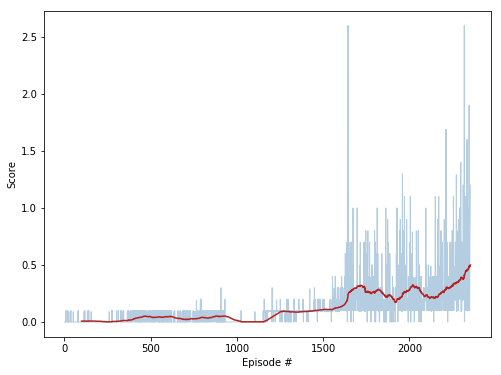

In [15]:
_, _, scores_solved = load_checkpoint('saved-checkpoints/checkpoint-solved.pth')
figure = plot_scores(scores_solved)

In [16]:
env.close()

# 1st failed model

In [6]:
from ddpg_agent import MultiAgent
import torch
import time
from collections import deque
from matplotlib import pyplot as plt

#initialise agents
agent = MultiAgent(seed=2, noise_start=0.5, update_every=2, gamma=1, t_stop_noise=30000)

In [9]:
def maddpg(agent, n_episodes=100, max_t=700):
    #n_episodes = 6000
    #max_t = 1000
    scores = []
    scores_deque = deque(maxlen=100)
    scores_avg = []
    
    start_time = time.time()     # Start time
    solved = False
    
    #agent_tuple = {"state_size": state_size, "action_size": action_size, "random_seed": 2,}
    #agents = [Agent(**agent_tuple) for _ in range(num_agents)]

    for i_episode in range(1, n_episodes+1):
        rewards = []
        env_info = env.reset(train_mode=False)[brain_name]    # reset the environment    
        #for agent in agents:
        #    agent.reset()
        state = env_info.vector_observations                  # get the current state (for each agent)
        
        # loop over steps
        for t in range(max_t):
            # select an action
            action = agent.act(state)
            # take action in environment and set parameters to new values
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            rewards_ = env_info.rewards
            done = env_info.local_done
            # update and train agent with returned information
            agent.step(state, action, rewards_, next_state, done)
            state = next_state
            rewards.append(rewards_)
            if any(done):
                break

        # calculate episode reward as maximum of individually collected rewards of agents
        episode_reward = np.max(np.sum(np.array(rewards),axis=0))
        
        scores.append(episode_reward)             # save most recent score to overall score array
        scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
        current_avg_score = np.mean(scores_deque)
        scores_avg.append(current_avg_score)      # save average of last 100 scores to average score array
    
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score),end="")
        
        # log average score every 200 episodes
        if i_episode % 200 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score))

        # break and report success if environment is solved
        if np.mean(scores_deque)>=.5 and solved == False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            agent.save_agents()
            solved = True
    
    time_elapsed = time.time() - start_time
    print("\nTime Elapse: {:.3f}".format(time_elapsed))
    
    return scores

Episode 200	Average Score: 0.005
Episode 400	Average Score: 0.000
Episode 600	Average Score: 0.000
Episode 800	Average Score: 0.002
Episode 1000	Average Score: 0.000
Episode 1200	Average Score: 0.000
Episode 1400	Average Score: 0.002
Episode 1600	Average Score: 0.008
Episode 1800	Average Score: 0.014
Episode 2000	Average Score: 0.008
Episode 2200	Average Score: 0.002
Episode 2400	Average Score: 0.001
Episode 2600	Average Score: 0.001
Episode 2800	Average Score: 0.011
Episode 3000	Average Score: 0.032
Episode 3200	Average Score: 0.040
Episode 3400	Average Score: 0.033
Episode 3600	Average Score: 0.034
Episode 3800	Average Score: 0.037
Episode 4000	Average Score: 0.016
Episode 4200	Average Score: 0.002
Episode 4400	Average Score: 0.018
Episode 4600	Average Score: 0.046
Episode 4800	Average Score: 0.028
Episode 5000	Average Score: 0.061
Episode 5200	Average Score: 0.076
Episode 5400	Average Score: 0.083
Episode 5600	Average Score: 0.085
Episode 5800	Average Score: 0.080
Episode 6000	Avera

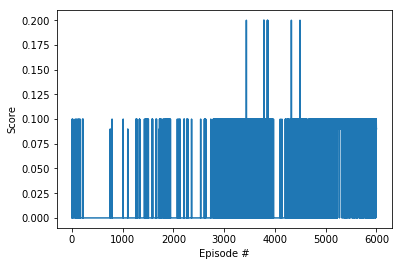

In [10]:
scores = maddpg(agent, 6000, 1000)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
env.close()